In [1]:
import os
import numpy as np
import pyedflib
from scipy.stats import zscore
from scipy.signal import stft
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ⚙️ 설정
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"
seq_len = 10
batch_size = 16
epochs = 50
learning_rate = 0.0001

label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}

In [2]:
# 1️⃣ 데이터 로드
def load_ecg_and_labels(sn_id, root_dir):
    base = f"SN{int(sn_id):03d}"
    ecg_path = os.path.join(root_dir, f"{base}.edf")
    label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")
    if not os.path.exists(ecg_path) or not os.path.exists(label_path):
        print(f"❌ 파일 없음: {base}")
        return [], []

    with pyedflib.EdfReader(ecg_path) as ecg_reader:
        ecg_signal = ecg_reader.readSignal(7)

    with pyedflib.EdfReader(label_path) as label_reader:
        onsets, durations, labels = label_reader.readAnnotations()

    segments, segment_labels = [], []
    for onset, duration, label in zip(onsets, durations, labels):
        label_str = label.decode() if isinstance(label, bytes) else label
        if label_str not in label_map:
            continue
        start = int(onset * 256)
        num_segments = int(duration // 30)
        for i in range(num_segments):
            seg_start = start + i * 7680
            seg_end = seg_start + 7680
            if seg_end > len(ecg_signal):
                break
            segment = zscore(ecg_signal[seg_start:seg_end])
            if np.isnan(segment).any():
                continue
            segments.append(segment.astype(np.float32))
            segment_labels.append(label_map[label_str])
    return segments, segment_labels

In [3]:
# 2️⃣ STFT 함수
def compute_stft(segment, fs=256, nperseg=256, noverlap=128):
    f, t, Zxx = stft(segment, fs=fs, nperseg=nperseg, noverlap=noverlap)
    magnitude = np.abs(Zxx)
    return magnitude.T  # (time, freq)

In [4]:
# 3️⃣ STFT + 시퀀스 생성
def create_sequences_stft(segments, labels, seq_len=10):
    X, y = [], []
    for i in range(len(segments) - seq_len + 1):
        stft_seqs = []
        for seg in segments[i:i+seq_len]:
            stft_feat = compute_stft(seg)  # (time, freq)
            stft_seqs.append(stft_feat)  # (time, freq)
        X.append(np.stack(stft_seqs))  # (seq_len, time, freq)
        y.append(labels[i + seq_len - 1])
    return np.array(X), np.array(y)

def merge_data(data_dict):
    X_all, y_all = [], []
    for X, y in data_dict.values():
        if len(X) == 0:
            continue
        X_all.append(X)
        y_all.append(y)
    if len(X_all) == 0:
        return np.array([]), np.array([])
    return np.concatenate(X_all), np.concatenate(y_all)


In [5]:
# 4️⃣ Dataset
class SleepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
# 5️⃣ CNN-STFT-LSTM 모델
class CNN_STFT_LSTM(nn.Module):
    def __init__(self, time_bins, freq_bins, cnn_out=64, lstm_hidden=128, num_classes=4):
        super(CNN_STFT_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, cnn_out, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(cnn_out),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # (batch*seq, channels, 1, 1)
        )
        self.lstm = nn.LSTM(input_size=cnn_out, hidden_size=lstm_hidden, num_layers=2, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        batch_size, seq_len, time_bins, freq_bins = x.shape
        x = x.view(batch_size * seq_len, 1, time_bins, freq_bins)  # (batch*seq, 1, time, freq)
        x = self.cnn(x)  # (batch*seq, channels, 1, 1)
        x = x.view(batch_size, seq_len, -1)  # (batch, seq, channels)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [7]:
# 6️⃣ 학습 및 평가 함수
def train_model(model, loader, epochs=10, lr=0.0001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
        acc = correct / total if total > 0 else 0
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f} Acc: {acc:.4f}")

def evaluate_model(model, loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    print(classification_report(all_labels, all_preds, labels=[0,1,2,3], target_names=["W", "N1/2", "N3", "R"], zero_division=0))
    cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["W", "N1/2", "N3", "R"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

In [8]:
# 7️⃣ 데이터 로드 및 처리
train_X, train_y = [], []
val_data, test_data = {}, {}
for i in range(1, 155):
    segments, labels = load_ecg_and_labels(i, root_dir)
    if segments:
        X_seq, y_seq = create_sequences_stft(segments, labels, seq_len)
        if 1 <= i <= 93:
            train_X.append(X_seq)
            train_y.append(y_seq)
        elif 94 <= i <= 123:
            val_data[f"SN{i:03d}"] = (X_seq, y_seq)
        else:
            test_data[f"SN{i:03d}"] = (X_seq, y_seq)

train_X = np.concatenate(train_X)
train_y = np.concatenate(train_y)
time_bins, freq_bins = train_X.shape[2], train_X.shape[3]
print(f"✅ Train shape: {train_X.shape}, time={time_bins}, freq={freq_bins}")


❌ 파일 없음: SN014


❌ 파일 없음: SN064


❌ 파일 없음: SN135


✅ Train shape: (81795, 10, 61, 129), time=61, freq=129


In [9]:
# 8️⃣ 모델 학습
train_loader = DataLoader(SleepDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
model = CNN_STFT_LSTM(time_bins, freq_bins)
train_model(model, train_loader, epochs=epochs, lr=learning_rate)

Epoch [1/50] Loss: 6084.0413 Acc: 0.5025


Epoch [2/50] Loss: 5761.8771 Acc: 0.5217


Epoch [3/50] Loss: 5588.1678 Acc: 0.5306


Epoch [4/50] Loss: 5459.9679 Acc: 0.5370


Epoch [5/50] Loss: 5346.8437 Acc: 0.5427


Epoch [6/50] Loss: 5236.6933 Acc: 0.5495


Epoch [7/50] Loss: 5118.9284 Acc: 0.5578


Epoch [8/50] Loss: 4975.5691 Acc: 0.5696


Epoch [9/50] Loss: 4844.6153 Acc: 0.5828


Epoch [10/50] Loss: 4718.8948 Acc: 0.5986


Epoch [11/50] Loss: 4595.4286 Acc: 0.6084


Epoch [12/50] Loss: 4504.2853 Acc: 0.6178


Epoch [13/50] Loss: 4386.7642 Acc: 0.6292


Epoch [14/50] Loss: 4298.1652 Acc: 0.6364


Epoch [15/50] Loss: 4196.5431 Acc: 0.6452


Epoch [16/50] Loss: 4114.1043 Acc: 0.6548


Epoch [17/50] Loss: 4020.7112 Acc: 0.6643


Epoch [18/50] Loss: 3934.6378 Acc: 0.6713


Epoch [19/50] Loss: 3862.2540 Acc: 0.6789


Epoch [20/50] Loss: 3787.3083 Acc: 0.6838


Epoch [21/50] Loss: 3711.9788 Acc: 0.6914


Epoch [22/50] Loss: 3634.9635 Acc: 0.6980


Epoch [23/50] Loss: 3579.4316 Acc: 0.7037


Epoch [24/50] Loss: 3506.9264 Acc: 0.7104


Epoch [25/50] Loss: 3438.9246 Acc: 0.7170


Epoch [26/50] Loss: 3382.4389 Acc: 0.7215


Epoch [27/50] Loss: 3318.9603 Acc: 0.7259


Epoch [28/50] Loss: 3259.8012 Acc: 0.7318


Epoch [29/50] Loss: 3200.1862 Acc: 0.7361


Epoch [30/50] Loss: 3142.4110 Acc: 0.7423


Epoch [31/50] Loss: 3104.5962 Acc: 0.7457


Epoch [32/50] Loss: 3036.4438 Acc: 0.7515


Epoch [33/50] Loss: 2980.9433 Acc: 0.7556


Epoch [34/50] Loss: 2937.4859 Acc: 0.7589


Epoch [35/50] Loss: 2875.8197 Acc: 0.7645


Epoch [36/50] Loss: 2833.8205 Acc: 0.7688


Epoch [37/50] Loss: 2790.6192 Acc: 0.7726


Epoch [38/50] Loss: 2735.4025 Acc: 0.7765


Epoch [39/50] Loss: 2695.2143 Acc: 0.7803


Epoch [40/50] Loss: 2641.1920 Acc: 0.7859


Epoch [41/50] Loss: 2602.0678 Acc: 0.7885


Epoch [42/50] Loss: 2560.4031 Acc: 0.7918


Epoch [43/50] Loss: 2508.7499 Acc: 0.7968


Epoch [44/50] Loss: 2482.4234 Acc: 0.7984


Epoch [45/50] Loss: 2427.7074 Acc: 0.8022


Epoch [46/50] Loss: 2389.5284 Acc: 0.8076


Epoch [47/50] Loss: 2354.1372 Acc: 0.8104


Epoch [48/50] Loss: 2315.2056 Acc: 0.8129


Epoch [49/50] Loss: 2282.5117 Acc: 0.8177


Epoch [50/50] Loss: 2234.7882 Acc: 0.8197



📊 Validation (전체) 평가


              precision    recall  f1-score   support

           W       0.37      0.56      0.44      4851
        N1/2       0.51      0.54      0.52     11507
          N3       0.43      0.23      0.30      5008
           R       0.36      0.25      0.30      3633

    accuracy                           0.44     24999
   macro avg       0.41      0.40      0.39     24999
weighted avg       0.44      0.44      0.43     24999



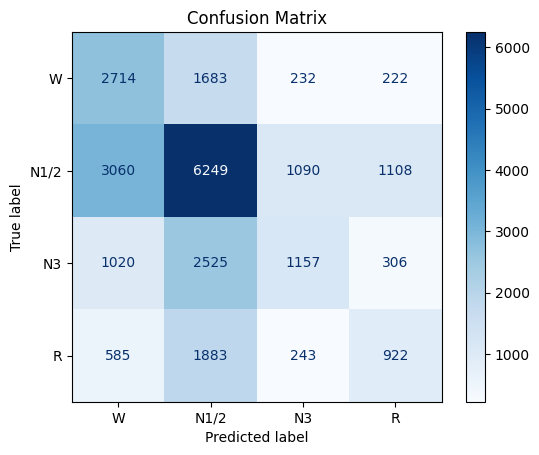


📊 Test (전체) 평가


              precision    recall  f1-score   support

           W       0.49      0.60      0.54      4228
        N1/2       0.54      0.59      0.56     13288
          N3       0.45      0.28      0.35      5803
           R       0.33      0.32      0.32      4280

    accuracy                           0.48     27599
   macro avg       0.45      0.45      0.44     27599
weighted avg       0.48      0.48      0.48     27599



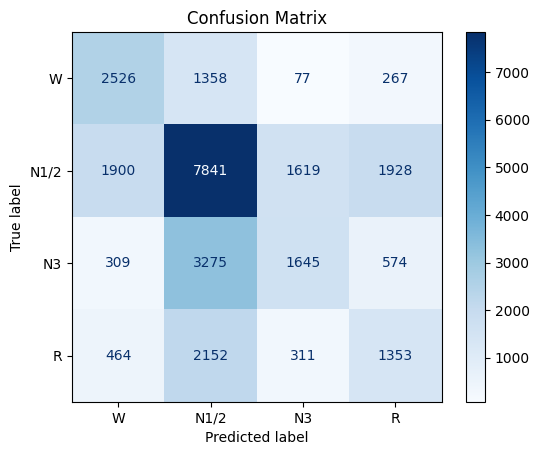

In [10]:
# 9️⃣ 전체 평가
X_val_all, y_val_all = merge_data(val_data)
if len(X_val_all) > 0:
    print("\n📊 Validation (전체) 평가")
    evaluate_model(model, DataLoader(SleepDataset(X_val_all, y_val_all), batch_size=batch_size, shuffle=False))

X_test_all, y_test_all = merge_data(test_data)
if len(X_test_all) > 0:
    print("\n📊 Test (전체) 평가")
    evaluate_model(model, DataLoader(SleepDataset(X_test_all, y_test_all), batch_size=batch_size, shuffle=False))